In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import normalize

import mygene

import anndata
import networkx as nx
import matplotlib.pyplot as plt

from itertools import count
import itertools
from scipy.spatial import distance_matrix

import seaborn as sns
import math
from slingshot import Slingshot

from itertools import combinations
import bottleneck as bn
from scipy import interpolate
from collections import defaultdict
#import statsmodels.api as sm
import statsmodels as sm

import scipy.stats
from itertools import combinations_with_replacement


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
#sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1+computecanada anndata==0.8.0+computecanada umap==0.5.1+computecanada numpy==1.21.4 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.9 louvain==0.7.0+computecanada pynndescent==0.5.2+computecanada


In [13]:
section_id = '151676'

input_dir = './gvae_model/data'
#input_dir = './human_cortex_data/151676'
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading gvae_model/data/151676_filtered_feature_bc_matrix.h5
 (0:00:02)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# STAGATE PREPROCESSING
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000)
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

# read the annotation
#Ann_df = pd.read_csv(os.path.join(input_dir, 'spatial', section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
#Ann_df.columns = ['Ground Truth']

#adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

plt.rcParams["figure.figsize"] = (3, 3)
#sc.pl.spatial(adata, img_key="hires")

normalizing counts per cell
    finished (0:00:00)


In [13]:
# add gene expression
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors

def weighted_distance_matrix(adata, k, partial=False):  # computes the spatial distance matrix
    # euclidian distance matrix
    adata.obsp["spa_distances"] = distance_matrix(adata.obsm['spatial'], adata.obsm['spatial'])
    print('yeehaw')
    # find kth nearest neighbour
    nbrs = NearestNeighbors(n_neighbors=k).fit(adata.obsm['spatial'])
    distances, indices = nbrs.kneighbors(adata.obsm['spatial'])
    print('wahoo')
    
    print(distances)
    print(indices)
    
    # compute affinity matrix
    aff = np.zeros((adata.n_obs, adata.n_obs))
    if partial:
        for i in range(len(aff)):
            # find distance of kth nearest neighbour
            sigma = distances[i][k-1]
            for j in range(k):
                # compute affinity with gaussian kernel
                index = indices[i][j]
                kernel = np.exp(-(distances[i][j]) ** 2 / (sigma ** 2))
                # sigma = ??
                #kernel = np.exp(-(adata_pca.obsp["gene_distances"][i][j]-mu) ** 2 / (sigma ** 2))
                #print(kernel)
                aff[i][index] = kernel
        

    else:
        for i in range(len(aff)):
            #mu = np.mean(distances[i])
            # find distance of kth nearest neighbour
            sigma = distances[i][k-1]
            for j in range(len(aff[i])):
                # compute affinity with gaussian kernel
                kernel = np.exp(-(adata.obsp["spa_distances"][i][j]) ** 2 / (sigma ** 2))
                # sigma = ??
                #kernel = np.exp(-(adata_pca.obsp["gene_distances"][i][j]-mu) ** 2 / (sigma ** 2))
                #print(kernel)
                aff[i][j] = kernel

    # symmetrize
    aff = (aff + np.transpose(aff))/2
    # normalize row
    aff = normalize(aff, axis=1, norm="l1")
    return aff


def affinity_matrix(adata, k, partial=False):  # computes the gene distance matrix
    # PCA
    #adata_pca = PCA(adata)
    # euclidian distance matrix
    adata.obsp["gene_distances"] = distance_matrix(adata.obsm['X_pca'], adata.obsm['X_pca'])  #len(adata)xlen(adata)
    #print(adata_pca.obsp["gene_distances"])
    # find kth nearest neighbour
    nbrs = NearestNeighbors(n_neighbors=k).fit(adata.obsm["X_pca"])
    distances, indices = nbrs.kneighbors(adata.obsm["X_pca"])
    #print(distances)
    #print(indices)
    # compute affinity matrix
    aff = np.zeros((adata.n_obs, adata.n_obs))
    if partial:
        for i in range(len(aff)):
            # find distance of kth nearest neighbour
            sigma = distances[i][k-1]
            for j in range(k):
                # compute affinity with gaussian kernel
                index = indices[i][j]
                kernel = np.exp(-(distances[i][j]) ** 2 / (sigma ** 2))
                # sigma = ??
                #kernel = np.exp(-(adata_pca.obsp["gene_distances"][i][j]-mu) ** 2 / (sigma ** 2))
                #print(kernel)
                aff[i][index] = kernel
        

    else:
        for i in range(len(aff)):
            #mu = np.mean(distances[i])
            # find distance of kth nearest neighbour
            sigma = distances[i][k-1]
            for j in range(len(aff[i])):
                # compute affinity with gaussian kernel
                kernel = np.exp(-(adata.obsp["spa_distances"][i][j]) ** 2 / (sigma ** 2))
                # sigma = ??
                #kernel = np.exp(-(adata_pca.obsp["gene_distances"][i][j]-mu) ** 2 / (sigma ** 2))
                #print(kernel)
                aff[i][j] = kernel

    #print(aff)
    # symmetrize
    aff = (aff + np.transpose(aff))/2
     # normalize row
    aff = normalize(aff, axis=1, norm="l1")
    #print(aff)
    
    return aff
            

alpha = 0.5
#grouped_pcw4 = PCA(grouped_pcw4)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
# compute distance matrix
#grouped_pcw4.obsp["spa_distances"] = distance_matrix(grouped_pcw4.obsm['spatial_coord'].to_numpy(), grouped_pcw4.obsm['spatial_coord'].to_numpy())
# compute distance matrix w/ gaussian kernel
adata.obsp["gau_spa_distances"] = weighted_distance_matrix(adata, k=15)
# compute affinity matrix of gene expression
adata.obsp["aff_matrix"] = affinity_matrix(adata, k=15)
# aggregate using element-wise multiplication
# grouped_pcw4.obsp["agg_matrix"] = np.multiply(grouped_pcw4.obsp["gau_spa_distances"], grouped_pcw4.obsp["aff_matrix"])
adata.obsp["agg_matrix"] = np.add(alpha*adata.obsp["gau_spa_distances"], (1-alpha)*adata.obsp["aff_matrix"])

print(adata.obsp["agg_matrix"])

computing PCA
    with n_comps=50
    finished (0:00:27)
yeehaw
wahoo
[[0.         1.         1.         ... 2.23606798 2.23606798 2.82842712]
 [0.         1.         1.         ... 2.23606798 2.23606798 2.23606798]
 [0.         1.         1.         ... 2.         2.23606798 2.23606798]
 ...
 [0.         1.         1.         ... 2.         2.23606798 2.23606798]
 [0.         1.         1.         ... 2.23606798 2.23606798 2.23606798]
 [0.         1.         1.         ... 2.23606798 2.23606798 2.82842712]]
[[    0   119 38630 ...   121   239   242]
 [    1 38631   120 ... 38633   242 38517]
 [    2   121     1 ... 38517 38634   243]
 ...
 [38743   113 38628 ... 38745   233 38515]
 [38744   114 38743 ... 38627   116   232]
 [38745   115 38744 ...   113 38515   236]]
[[0.17047745 0.0456834  0.0283532  ... 0.         0.         0.        ]
 [0.04308914 0.13718568 0.04147405 ... 0.         0.         0.        ]
 [0.02607734 0.04044159 0.16034123 ... 0.         0.         0.        ]
 ..

In [77]:
alpha = 0.5

for adata in adata_list:
    sc.pp.normalize_total(adata, target_sum=1e4)
    
    #grouped_pcw4 = PCA(grouped_pcw4)
    sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
    # compute distance matrix
    #grouped_pcw4.obsp["spa_distances"] = distance_matrix(grouped_pcw4.obsm['spatial_coord'].to_numpy(), grouped_pcw4.obsm['spatial_coord'].to_numpy())
    # compute distance matrix w/ gaussian kernel
    adata.obsp["gau_spa_distances"] = weighted_distance_matrix(adata, k=15)
    # compute affinity matrix of gene expression
    adata.obsp["aff_matrix"] = affinity_matrix(adata, k=15)
    # aggregate using element-wise multiplication
    #grouped_pcw4.obsp["agg_matrix"] = np.multiply(grouped_pcw4.obsp["gau_spa_distances"], grouped_pcw4.obsp["aff_matrix"])
    adata.obsp["agg_matrix"] = np.add(alpha*adata.obsp["gau_spa_distances"], (1-alpha)*adata.obsp["aff_matrix"])

    print(adata.obsp["agg_matrix"])

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
[[0.06916603 0.0379501  0.05103073 ... 0.01033488 0.01074035 0.00867121]
 [0.03979024 0.07185268 0.05189273 ... 0.00779464 0.00918421 0.00790184]
 [0.05075678 0.04904665 0.06904916 ... 0.00951476 0.01240643 0.01070074]
 ...
 [0.01257924 0.00962592 0.01141315 ... 0.08087004 0.05847788 0.03210957]
 [0.01250602 0.01085188 0.01423663 ... 0.05555674 0.07695257 0.03980369]
 [0.01051502 0.0097233  0.01278804 ... 0.02810054 0.03648691 0.07160099]]
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
[[0.07114324 0.05165606 0.05102463 ... 0.01169964 0.01341709 0.00982907]
 [0.05575316 0.07482903 0.0420895  ... 0.00831494 0.00954682 0.00793638]
 [0.05053599 0.038842   0.06985761 ... 0.00955176 0.01075972 0.0103216 ]
 ...
 [0.01341413 0.01004179 0.01158473 ... 0.07451497 0.05509076 0.04953803]
 [0.01471477 0.0110267  0.01248248 ... 0.05621932 0.07490031 0.05504338]
 [0.01138857 0.00967059 0.01265037 ... 0.05291758 0.05761655 0.07857947]]
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[[0.06449985 0.05308579 0.02163334 ... 0.00289155 0.00147003 0.00100404]
 [0.05566023 0.06717181 0.01309026 ... 0.00213682 0.00093658 0.0005106 ]
 [0.02189544 0.01292159 0.06592206 ... 0.0017192  0.00106677 0.00106799]
 ...
 [0.00334131 0.00253604 0.00179448 ... 0.0676666  0.0347313  0.0470786 ]
 [0.0026142  0.00171064 0.0017136  ... 0.03424798 0.0751354  0.04944858]
 [0.00143777 0.00075097 0.00138144 ... 0.04742168 0.04978835 0.07168153]]
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[[0.0642198  0.04790074 0.0415389  ... 0.00153341 0.00277813 0.00245279]
 [0.05022145 0.06819186 0.05177224 ... 0.00156104 0.00198764 0.00080752]
 [0.03552927 0.04238494 0.05639276 ... 0.00216162 0.00179675 0.00044784]
 ...
 [0.00161835 0.0014715  0.00234043 ... 0.06619188 0.0010853  0.00132682]
 [0.00354655 0.00226634 0.00235312 ... 0.00124554 0.0682619  0.04460817]
 [0.00369399 0.00108623 0.00069193 ... 0.00148615 0.04629326 0.07339861]]
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[[0.05627704 0.04174439 0.02849142 ... 0.00123127 0.00131667 0.00227304]
 [0.04112935 0.05449523 0.03829021 ... 0.00124365 0.00141182 0.00194676]
 [0.0310297  0.04220057 0.06103034 ... 0.00096885 0.00097794 0.00200882]
 ...
 [0.0015098  0.00169846 0.00111153 ... 0.06553825 0.04835072 0.03492798]
 [0.00155227 0.0018538  0.00107871 ... 0.05139429 0.06857971 0.04848725]
 [0.00204614 0.00195178 0.00169188 ... 0.03957649 0.05157344 0.06785466]]
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[[0.06269909 0.05065692 0.03840558 ... 0.00149223 0.00092634 0.00117693]
 [0.05133174 0.06363994 0.04519472 ... 0.00205514 0.00128424 0.00144559]
 [0.0411012  0.04751294 0.06760467 ... 0.00080554 0.00058643 0.00093797]
 ...
 [0.00172551 0.00230738 0.00082364 ... 0.05788498 0.03359008 0.0394699 ]
 [0.00115259 0.00155147 0.00064518 ... 0.0353143  0.06111239 0.04331425]
 [0.00150043 0.00178939 0.00105736 ... 0.04182168 0.04374286 0.06192366]]
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[[6.33983582e-02 3.83638850e-02 2.89098785e-02 ... 4.47138657e-03
  4.01163246e-03 7.90786707e-03]
 [3.67244377e-02 6.13167642e-02 4.26271877e-02 ... 2.00803269e-04
  2.54678431e-04 2.22583455e-04]
 [2.70345375e-02 4.07911727e-02 5.59846214e-02 ... 2.72312419e-04
  4.63795412e-04 9.21249085e-05]
 ...
 [5.76367224e-03 2.61724619e-04 4.57090049e-04 ... 6.59229014e-02
  4.78188630e-02 3.48390439e-02]
 [5.28626148e-03 3.39341068e-04 7.95850031e-04 ... 4.71301282e-02
  6.54775088e-02 4.29339077e-02]
 [9.54976736e-03 2.71796006e-04 1.44873114e-04 ... 3.59395768e-02
  4.52207814e-02 6.62509698e-02]]
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[[6.23406405e-02 3.50627110e-02 1.57185679e-02 ... 1.36633547e-03
  6.57687387e-03 2.87628730e-03]
 [3.70874362e-02 6.08802356e-02 1.06669022e-02 ... 1.53674917e-03
  2.39974484e-05 2.12826731e-03]
 [1.52199684e-02 9.51211810e-03 5.50138903e-02 ... 1.39363971e-03
  1.40605650e-04 2.64112937e-03]
 ...
 [1.47039546e-03 1.99936171e-03 2.17526962e-03 ... 7.03625438e-02
  7.74273237e-04 1.57620772e-03]
 [7.97894679e-03 3.51967606e-05 2.47408492e-04 ... 8.64666323e-04
  7.17527684e-02 3.53924767e-02]
 [2.39371099e-03 2.14129842e-03 3.18797493e-03 ... 1.21969979e-03
  3.71341877e-02 6.72186842e-02]]
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


[[0.05558926 0.04201882 0.033034   ... 0.00250925 0.00242878 0.00180057]
 [0.04543824 0.06122874 0.0460869  ... 0.00270742 0.00190035 0.00115736]
 [0.03717292 0.04780691 0.06187685 ... 0.00215642 0.00201929 0.0013958 ]
 ...
 [0.00279833 0.0025296  0.00232608 ... 0.05948679 0.04306883 0.03330303]
 [0.00256722 0.00168287 0.00206447 ... 0.04125963 0.05685432 0.0401421 ]
 [0.0020802  0.00112023 0.00155975 ... 0.03401134 0.04277796 0.06089889]]


In [14]:
import gc
import numpy as np
import pandas as pd
import math
import scanpy.plotting
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.functional as F
import anndata
import pyro
import pyro.distributions as dist
from scipy.sparse import csc_matrix
from scvi.module.base import PyroBaseModuleClass
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from umap import UMAP
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam,AdagradRMSProp
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
import os

#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

class GraphConvolution(Module):  
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        # if bias:
        #     self.bias = Parameter(torch.FloatTensor(out_features))  # bias?
        # else:
        #     self.register_parameter('bias', None)
        # self.reset_parameters()

    # def reset_parameters(self):
    #     stdv = 1. / math.sqrt(self.weight.size(1))
    #     self.weight.data.uniform_(-stdv, stdv)
    #     if self.bias is not None:
    #         self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input_layer, adj):
        # support = torch.mm(input_layer, self.weight)
        # output = torch.spmm(adj, support)
        output = torch.spmm(adj, input_layer)
        return output
        

    # def __repr__(self):
    #     return self.__class__.__name__ + ' (' \
    #            + str(self.in_features) + ' -> ' \
    #            + str(self.out_features) + ')'

class Encoder(nn.Module):
    def __init__(self, in_dim, z_dim, hidden_dim, dropout):
        super().__init__()
        #self.gc1 = GraphConvolution(in_dim, nhid)
        self.gc1 = GraphConvolution(in_dim, in_dim)
        #self.gc1 = nn.Linear(in_dim, nhid)
        self.dropout = dropout
        #self.fc1 = nn.Sequential(nn.Linear(nhid, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.Softplus())
        #self.fc1 = nn.Linear(nhid, hidden_dim)
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        #self.fc3 = nn.Linear(256, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()
            

    def forward(self, x, adj):
        ###
        x = self.gc1(x, adj)  # ReLU(AXW)
        #x = F.relu(self.gc1(x, adj))  # ReLU(AXW)
        #x = F.dropout(x, self.dropout, training=self.training)
        hidden = self.softplus(self.fc1(x))
        #hidden1 = self.softplus(self.fc3(hidden))
        z_loc = self.fc21(hidden)  # shouldn't use activation function here normal dist mean can be <0
        z_scale = torch.exp(self.fc22(hidden))  # keep for std
        # latent z
        return z_loc, z_scale

    
class Decoder(nn.Module):
    def __init__(self, in_dim, z_dim, hidden_dim):
        super().__init__()

        #self.fc1 = nn.Sequential(nn.Linear(z_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.Softplus())
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        #self.fc3 = nn.Linear(hidden_dim, 256)
        #self.fc21 = nn.Linear(hidden_dim, in_dim)
        #self.fc22 = nn.Linear(hidden_dim, in_dim)
        self.fc21 = nn.Linear(hidden_dim, in_dim)
        self.fc22 = nn.Linear(hidden_dim, in_dim)

        self.softplus = nn.Softplus()

    def forward(self, z):
        ###
        #hidden = self.softplus(self.fc1(z))
        hidden = self.softplus(self.fc1(z))
        #hidden1 = self.softplus(self.fc3(hidden))
        count = self.softplus(self.fc21(hidden))
        prob = self.softplus(self.fc22(hidden))
        
        ######
        return count, prob



class VAE(PyroBaseModuleClass):
    def __init__(self, n_input, n_latent, hidden_dim, dropout, bias=False):
        super().__init__()
        self.n_latent = n_latent
        self.n_input = n_input
        self.encoder = Encoder(n_input, n_latent, hidden_dim,  dropout)
        self.decoder = Decoder(n_input, n_latent, hidden_dim)
        
        self.log_theta = torch.nn.Parameter(torch.randn(n_input))  # both free params, only one should be free
        self.gate_logits = torch.nn.Parameter(torch.randn(n_input),requires_grad=True) # free param, decode from z ask yumin
        

    def model(self, x,adj):
        pyro.module("decoder", self)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.n_latent)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.n_latent)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))  # loss
            
            
            count, prob = self.decoder(z)
            ######
            x_dist = dist.ZeroInflatedNegativeBinomial(total_count=count+1, probs=prob, gate_logits=self.gate_logits)
            rx=pyro.sample("obs1", x_dist.to_event(1), obs=x)  # loss function calculated added tgt
            return rx
        
        
#              # get the "normalized" mean of the negative binomial
#             px_scale, px_dropout = self.decoder(z)
            
#             # get the mean of the negative binomial
#             #px_scale
#             # log_library = library_size  
#             px_rate =px_scale # torch.exp(library_size) * px_scale
#             # get the dispersion parameter
#             theta = torch.exp(self.log_theta)
#             glog=self.gate_logits
#             # build count distribution
#             nb_logits = (px_rate + 1e-4).log() - (theta + 1e-4).log()
#             # nb_logits = (px_rate + 5.0e-2).log() - (theta + 5.0e-2).log()

#             # x_dist = dist.ZeroInflatedNegativeBinomial(total_count=theta, logits=nb_logits, gate_logits=glog)
#             x_dist = dist.ZeroInflatedNegativeBinomial(total_count=theta, logits=nb_logits, gate_logits=px_dropout)
#             # score against actual counts
#             rx=pyro.sample("obs1", x_dist.to_event(1), obs=x)
#             return rx
        
        
    def guide(self, x,adj):
        pyro.module("encoder", self)
        with pyro.plate("data", x.shape[0]):
            x_ = torch.log(1+x)
            [qz_m, qz_v] = self.encoder(x_,adj)
            pyro.sample("latent", dist.Normal(qz_m,qz_v).to_event(1))  # loss nearest to std norm dist in vae(can be other dist)


    def getZ(self, x, adj):  # 
        z_loc, z_scale = self.encoder(x,adj)
        #z = dist.Normal(z_loc, z_scale).sample()  # try
        #z = z_loc + z_scale
        z = z_loc
        return z

    

def train(svi, train_loader, adj, use_cuda=True):
    epoch_loss = 0
    for x in train_loader:
        #print(x)
        if use_cuda:
            x = x.cuda()
            adj = adj.cuda()
        epoch_loss += svi.step(x,adj)

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train


INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [20]:
torch.cuda.is_available()
gc.collect()
torch.cuda.empty_cache()

In [7]:
# # CELL CELL INTERACTION
# # adata_GVAE_train05_mclust_best.h5ad
# a = anndata.read_h5ad('adata_GVAE_train05.h5ad')
# # adata_GVAE_train05_mclust_best.h5ad
# #adata_z = anndata.read_h5ad('adata_GVAE_train05_mclust_best.h5ad')
# a_z = anndata.read_h5ad(f'test_gvae2/test_13.h5ad')

# #adata = anndata.read_h5ad('adata_STAGATE.h5ad')
# #adata_z = anndata.read_h5ad('adata_STAGATE_mclust.h5ad')

# a_z.obs['mclust'] = a_z.obs['mclust'].astype('int')
# a_z.obs['mclust'] = a_z.obs['mclust'].astype('str')
# a_z.obs['mclust'] = a_z.obs['mclust'].astype('category')

# a.obs['mclust'] = np.asarray(a_z.obs['mclust'])
# a.obsm['GVAE'] = a_z.X

In [7]:
# import scipy.stats
# from itertools import combinations_with_replacement
# import numpy as np
# import pandas as pd

# sig_list = []

# for c1, c2 in combinations_with_replacement(np.unique([1,2,3,4,5,6,7]), 2):
#     path = f"test_gvae2/cluster{c1}_{c2}_sig_results.csv"
#     df_sig = pd.read_csv(path)
#     sig_list.extend(df_sig["ligand_gene_symbol"])
#     sig_list.extend(df_sig["receptor_gene_symbol"])

# #results = pd.concat(sig_list, axis=1, ignore_index=False)
# #print(sig_list)

In [15]:
from pyro import poutine
import pyro.ops.jit
from pyro.infer.util import is_validation_enabled
from pyro.infer.enum import get_importance_trace
from pyro.poutine.util import prune_subsample_sites
from pyro.distributions.util import is_identically_zero, scale_and_mask
from pyro.infer.elbo import ELBO
from pyro.util import check_model_guide_match, check_site_shape, ignore_jit_warnings, warn_if_nan, warn_if_inf
from pyro.infer.util import (
    MultiFrameTensor,
    get_plate_stacks,
    is_validation_enabled,
    torch_item,
)
from pyro.util import check_if_enumerated, warn_if_nan


def updater(loss, model, guide, optim,x):
    with poutine.trace(param_only=True) as param_capture:
            loss = loss.loss_and_grads(model, guide, x)

    params = set(site["value"].unconstrained() for site in param_capture.trace.nodes.values())

    # actually perform gradient steps
    # torch.optim objects gets instantiated for any params that haven't been seen yet
    optim(params)

    # zero gradients
    pyro.infer.util.zero_grads(params)

    if isinstance(loss, tuple):
        # Support losses that return a tuple, e.g. ReweightedWakeSleep.
        return type(loss)(map(torch_item, loss))
    else:
        return torch_item(loss)
    
    
def graphUpdater(loss, model, guide, optim,x,adj,i,start,end):
    with poutine.trace(param_only=True) as param_capture:
            loss = loss.loss_and_grads(model, guide, x, adj)

    params = set(site["value"].unconstrained() for site in param_capture.trace.nodes.values())

    # actually perform gradient steps
    # torch.optim objects gets instantiated for any params that haven't been seen yet
    optim(params)

    # zero gradients
    pyro.infer.util.zero_grads(params)

    if isinstance(loss, tuple):
        # Support losses that return a tuple, e.g. ReweightedWakeSleep.
        return type(loss)(map(torch_item, loss))
    else:
        return torch_item(loss)
    
    
def graphUpdater(loss, model, guide, optim, x, adj, i, start, end):
    '''
    new gcn updater, try to tackle big batch size issue
    '''
    with poutine.trace(param_only=True) as param_capture:
            loss = loss.loss_and_grads(model, guide, x, adj, i, start, end)

    params = set(site["value"].unconstrained() for site in param_capture.trace.nodes.values())

    # actually perform gradient steps
    # torch.optim objects gets instantiated for any params that haven't been seen yet
    optim(params)

    # zero gradients
    pyro.infer.util.zero_grads(params)

    if isinstance(loss, tuple):
        # Support losses that return a tuple, e.g. ReweightedWakeSleep.
        return type(loss)(map(torch_item, loss))
    else:
        return torch_item(loss)
    
    
def mySigmoid(z):
    '''
    shifted sigmoid transformation of given data
    args: 
    z: input data
    return:  
    out: data after shifted sigmoid transformation
    '''
    z = np.array(z)
    out = 2*1/(1+np.exp(-z))
    return out


class myELBO(ELBO):
    def __init__(self, geneWeight=None):
    
        super(myELBO, self).__init__()
        self.geneWeight=geneWeight
        
    def get_importance_trace(self,
    graph_type, max_plate_nesting, model, guide, args, kwargs,detach=False
):
        """
        Returns a single trace from the guide, which can optionally be detached,
        and the model that is run against it.
        """
        guide_trace = poutine.trace(guide, graph_type=graph_type).get_trace(*args, **kwargs)
        if detach:
            guide_trace.detach_()
        model_trace = poutine.trace(
            poutine.replay(model, trace=guide_trace), graph_type=graph_type
        ).get_trace(*args, **kwargs)
        if is_validation_enabled():
            check_model_guide_match(model_trace, guide_trace, max_plate_nesting)

        guide_trace = prune_subsample_sites(guide_trace)
        model_trace = prune_subsample_sites(model_trace)

        model_trace = self.compute_log_prob(model_trace)
        guide_trace.compute_score_parts()

            
        if is_validation_enabled():
            for site in model_trace.nodes.values():
                if site["type"] == "sample":
                    check_site_shape(site, max_plate_nesting)
            for site in guide_trace.nodes.values():
                if site["type"] == "sample":
                    check_site_shape(site, max_plate_nesting)

        return model_trace, guide_trace
    
    def _get_trace(self, model, guide, args, kwargs):
        """
        Returns a single trace from the guide, and the model that is run
        against it.
        """
        model_trace, guide_trace = self.get_importance_trace(
            "flat", self.max_plate_nesting, model, guide, args, kwargs
        )
        if is_validation_enabled():
            check_if_enumerated(guide_trace)
        return model_trace, guide_trace
    
    def differentiable_loss(self, model, guide, *args, **kwargs):
        """
        Computes the surrogate loss that can be differentiated with autograd
        to produce gradient estimates for the model and guide parameters
        """
        loss = 0.0
        surrogate_loss = 0.0
        for model_trace, guide_trace in self._get_traces(model, guide, args, kwargs):
            loss_particle, surrogate_loss_particle = self._differentiable_loss_particle(
                model_trace, guide_trace
            )
            surrogate_loss += surrogate_loss_particle / self.num_particles
            loss += loss_particle / self.num_particles
        warn_if_nan(surrogate_loss, "loss")
        return loss + (surrogate_loss - torch_item(surrogate_loss))

    def loss(self, model, guide, *args, **kwargs):
        """
        :returns: returns an estimate of the ELBO
        :rtype: float

        Evaluates the ELBO with an estimator that uses num_particles many samples/particles.
        """
        elbo = 0.0
        
        for model_trace, guide_trace in self._get_traces(model, guide, args, kwargs):
            elbo_particle = torch_item(my_log_sum(model_trace)) - torch_item(my_log_sum(guide_trace))
            elbo += elbo_particle / self.num_particles
        loss = -elbo
        warn_if_nan(loss, "loss")
        return loss
    
    def _differentiable_loss_particle(self, model_trace, guide_trace):
        elbo_particle = 0
        surrogate_elbo_particle = 0
        log_r = None
        # compute elbo and surrogate elbo
        #model_trace = compute_log_prob(model_trace)
        #guide_trace = compute_log_prob(guide_trace)
        for name, site in model_trace.nodes.items():
            if site["type"] == "sample":
                elbo_particle = elbo_particle + torch_item(site["log_prob_sum"])
                surrogate_elbo_particle = surrogate_elbo_particle + site["log_prob_sum"]

        for name, site in guide_trace.nodes.items():
            if site["type"] == "sample":
                
                log_prob, score_function_term, entropy_term = site["score_parts"]

                elbo_particle = elbo_particle - torch_item(site["log_prob_sum"])

                if not is_identically_zero(entropy_term):
                    surrogate_elbo_particle = (
                        surrogate_elbo_particle - entropy_term.sum()
                    )

                if not is_identically_zero(score_function_term):
                    if log_r is None:
                        log_r = _compute_log_r(model_trace, guide_trace)
                    site = log_r.sum_to(site["cond_indep_stack"])
                    surrogate_elbo_particle = (
                        surrogate_elbo_particle + (site * score_function_term).sum()
                    )

        return -elbo_particle, -surrogate_elbo_particle
    
    def _sum_rightmost(self,value, dim):
        r"""
        Sum out ``dim`` many rightmost dimensions of a given tensor.

        Args:
            value (Tensor): A tensor of ``.dim()`` at least ``dim``.
            dim (int): The number of rightmost dims to sum out.
        """
        if dim == 0:
            return value
        required_shape = value.shape[:-dim] + (-1,)
        return value.reshape(required_shape).sum(-1)
    
    def loss_and_grads(self, model, guide, *args, **kwargs):
        """
        :returns: returns an estimate of the ELBO
        :rtype: float

        Computes the ELBO as well as the surrogate ELBO that is used to form the gradient estimator.
        Performs backward on the latter. Num_particle many samples are used to form the estimators.
        """
        loss = 0.0
        # grab a trace from the generator
        for model_trace, guide_trace in self._get_traces(model, guide, args, kwargs):
            loss_particle, surrogate_loss_particle = self._differentiable_loss_particle(
                model_trace, guide_trace
            )
            loss += loss_particle / self.num_particles

            # collect parameters to train from model and guide
            trainable_params = any(
                site["type"] == "param"
                for trace in (model_trace, guide_trace)
                for site in trace.nodes.values()
            )

            if trainable_params and getattr(
                surrogate_loss_particle, "requires_grad", False
            ):
                surrogate_loss_particle = surrogate_loss_particle / self.num_particles
                surrogate_loss_particle.backward(retain_graph=self.retain_graph)
        warn_if_nan(loss, "loss")
        return loss
    
    def compute_log_prob(self, trace, site_filter=lambda name, site: True):
        """
        Compute the site-wise log probabilities of the trace.
        Each ``log_prob`` has shape equal to the corresponding ``batch_shape``.
        Each ``log_prob_sum`` is a scalar.
        Both computations are memoized.
        """
        
        for name, site in trace.nodes.items():
            if site["type"] == "sample" and site_filter(name, site):
                if "log_prob" not in site:
                    try:
                        if self.geneWeight is not None and name == 'obs':
                            #print(site["value"].shape)
                            log_p_gene = site["fn"].base_dist.log_prob(site["value"])*self.geneWeight
                            log_p = self._sum_rightmost(log_p_gene,1)#1 is the indicator of event, showed in model.sample.event
                            #log_p = site["fn"].log_prob(site["value"], *site["args"], **site["kwargs"])
                        else:
                            log_p = site["fn"].log_prob(
                            site["value"], *site["args"], **site["kwargs"]
                        )
                            # log_p = log_p.mean()
                        #print(log_p.shape)
                        
                    except ValueError as e:
                        _, exc_value, traceback = sys.exc_info()
                        shapes = self.format_shapes(last_site=site["name"])
                        raise ValueError(
                            "Error while computing log_prob at site '{}':\n{}\n{}".format(
                                name, exc_value, shapes
                            )
                        ).with_traceback(traceback) from e
                    site["unscaled_log_prob"] = log_p
                    log_p = scale_and_mask(log_p, site["scale"], site["mask"])
                    site["log_prob"] = log_p
                    site["log_prob_sum"] = log_p.sum()
                    # site["log_prob_sum"] = log_p.mean() #use mean to try to tackle large batch size nan issue
                    if is_validation_enabled():
                        warn_if_nan(
                            site["log_prob_sum"],
                            "log_prob_sum at site '{}'".format(name),
                        )
                        warn_if_inf(
                            site["log_prob_sum"],
                            "log_prob_sum at site '{}'".format(name),
                            allow_neginf=True,
                        )
        return trace
    
    
    def log_prob_sum(self, trace, site_filter=lambda name, site: True):
        """
        Compute the site-wise log probabilities of the trace.
        Each ``log_prob`` has shape equal to the corresponding ``batch_shape``.
        Each ``log_prob_sum`` is a scalar.
        The computation of ``log_prob_sum`` is memoized.

        :returns: total log probability.
        :rtype: torch.Tensor
        """
        result = 0.0
        for name, site in trace.nodes.items():
            if site["type"] == "sample" and site_filter(name, site):
                if "log_prob" not in site:
                    try:
                        if self.geneWeight is not None and name == 'obs':
                            #print(site["value"].shape)
                            log_p_gene = site["fn"].base_dist.log_prob(site["value"])*self.geneWeight
                            log_p = self._sum_rightmost(log_p_gene,1)#1 is the indicator of event, showed in model.sample.event
                            #log_p = site["fn"].log_prob(site["value"], *site["args"], **site["kwargs"])
                        else:
                            log_p = site["fn"].log_prob(
                            site["value"], *site["args"], **site["kwargs"]
                        )
                            # log_p = log_p.mean()
                        #print(log_p.shape)
                        
                    except ValueError as e:
                        _, exc_value, traceback = sys.exc_info()
                        shapes = self.format_shapes(last_site=site["name"])
                        raise ValueError(
                            "Error while computing log_prob at site '{}':\n{}\n{}".format(
                                name, exc_value, shapes
                            )
                        ).with_traceback(traceback) from e
                    site["unscaled_log_prob"] = log_p
                    log_p = scale_and_mask(log_p, site["scale"], site["mask"])
                    site["log_prob"] = log_p
                    site["log_prob_sum"] = log_p.sum()
                    # site["log_prob_sum"] = log_p.mean() #use mean to try to tackle large batch size nan issue
                    if is_validation_enabled():
                        warn_if_nan(
                            site["log_prob_sum"],
                            "log_prob_sum at site '{}'".format(name),
                        )
                        warn_if_inf(
                            site["log_prob_sum"],
                            "log_prob_sum at site '{}'".format(name),
                            allow_neginf=True,
                        )
                else:
                    log_p = site["log_prob_sum"]
                    
                result = result + log_p
                
        return result

In [ ]:
# for i, x in enumerate(train_loader):
#     geneWeights1 = torch.tensor(transfer_to_ranking_score(geneWeights[start:end].toarray()))
#     if use_cuda:
#         x = x.to('cuda:6')
#         geneWeights1 = geneWeights1.to('cuda:6')
#         loss = graphUpdater(myELBO(geneWeights1),vae.model,vae.guide)
#         epoch_loss += loss

In [21]:
class H5ADataSet(Dataset):
    def __init__(self, adata):
        self.data = adata

    def __len__(self):
        return self.data.X.shape[0]

    def __getitem__(self, idx):
        x = csc_matrix(self.data.X[idx])[0].toarray()[0]
        x_tensor = x.astype(np.float32)
        return x_tensor

    
def load_data(adata):
    adj = adata.obsp["agg_matrix"]/100  # 154x154 for pcw4
    features = adata.obs.copy() #154x50
    return adj, features

dataset = adata
adj, features = load_data(dataset)

celldata = H5ADataSet(dataset)
print(celldata)

NUMGENS = adata.n_vars
#NUMGENS = 50
dimZ = 50
dimG = 128  # dim latent
BATCHSIZE = adata.n_obs
#BATCHSIZE = 256
LEARN_RATE = 1.0e-4
USE_CUDA = True
NUM_EPOCHS = 10
TEST_FREQUENCY=5
start=0
end=adata.n_vars-1
cell_loader = DataLoader(celldata, batch_size=BATCHSIZE)
#cell_loader = DataLoader(features, batch_size=BATCHSIZE)

pyro.clear_param_store()

# (self, n_input, n_latent, hidden_dim, n_clusters, dropout):
vae = VAE(NUMGENS, dimZ, dimG, 0.5, bias=True)
#vae = myGrphVAEPyroModule(NUMGENS, dimZ, dimG, 0.5)
#vae = NBlinearVAEPyroModule(NUMGENS, dimZ, dimG, 0.5)
if USE_CUDA:
    vae.cuda()
    
adam_args ={"lr":LEARN_RATE}
optimizer = ClippedAdam(adam_args)

elbo = Trace_ELBO(strict_enumeration_warning=False)
#geneWeights1 = torch.tensor(weights)
#if USE_CUDA:
#        geneWeights1 = geneWeights1.to('cuda')
myelbo = myELBO(geneWeight=None)

# note that simple_elbo takes a model, a guide, and their respective arguments as inputs
def gene_elbo(model, guide, *args, **kwargs):
    # get the mask and lamda keyword arguments passed to the model and guide
    mask = torch.cuda.BoolTensor(kwargs.pop('mask', []))
    lam = kwargs.pop('lam', 1.0)
    
    # run the guide and trace its execution
    guide_trace = pyro.poutine.trace(guide).get_trace(*args, **kwargs)
    # run the model and replay it against the samples from the guide
    model_trace = pyro.poutine.trace(
        pyro.poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
    # construct the elbo loss function
    
    model_trace.compute_log_prob()
    guide_trace.compute_log_prob()
    
#     count= 0
#     for name, site in guide_trace.nodes.items():
#         if site["type"] == "sample":
#             print(name)
#             log = site["log_prob"]
#             print(log)
#             print(log.size())
#             count += 1
#     print(count)
    
    #elbo_loss = -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())
    elbo_loss = -1*(myelbo.log_prob_sum(model_trace) - myelbo.log_prob_sum(guide_trace))
    #reg_loss = -lam*(model_trace.log_prob_sum(site_filter=lambda name, site: True) - guide_trace.log_prob_sum())
    
    return elbo_loss


svi = SVI(vae.model, vae.guide, optimizer, loss=gene_elbo)

gc.collect()
torch.cuda.empty_cache()

train_elbo = []
test_elbo = []

adj = torch.FloatTensor(adj)


# def train_gene(svi, train_loader, adj, use_cuda=True, mask=[], lam=1.0):
#     epoch_loss = 0
#     for x in train_loader:
#         #print(x)
#         if use_cuda:
#             x = x.cuda()
#             adj = adj.cuda()
#         epoch_loss += svi.step(x,adj,mask=[], lam=1.0)

#     normalizer_train = len(train_loader.dataset)
#     total_epoch_loss_train = epoch_loss / normalizer_train
#     return total_epoch_loss_train


for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, cell_loader, adj, use_cuda=USE_CUDA)
    #total_epoch_loss_train = train(svi, cell_loader, adj, start, end, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))
    #if epoch % TEST_FREQUENCY == 0:
        

# torch.save(vae,'./vae.pkl')


RuntimeError: CUDA out of memory. Tried to allocate 5.59 GiB (GPU 0; 15.78 GiB total capacity; 13.23 GiB already allocated; 1.70 GiB free; 13.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

AnnData object with n_obs × n_vars = 3460 × 50
computing neighbors
    using data matrix X directly


/tmp/ipykernel_16594/1603884862.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_z = anndata.AnnData(TZ)
/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


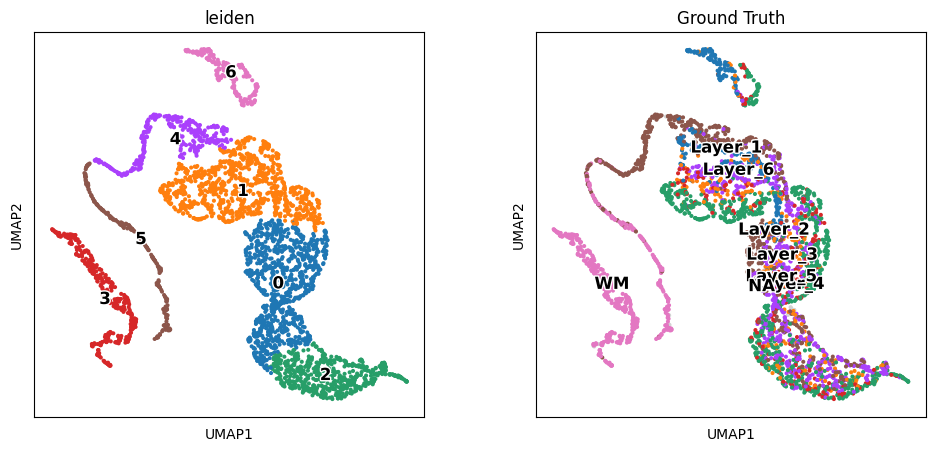

ARI: 0.17412338571639138  NMI: 0.3342896896059688


In [25]:
TZ = []
for x in cell_loader:
    if USE_CUDA:
        x = x.cuda()
        adj = adj.cuda()
    z = vae.getZ(x,adj)
    #z = vae.getZ(x,adj,start,end)
    zz = z.cpu().detach().numpy().tolist()
    TZ+=zz
TZ = np.array(TZ)
TZ = pd.DataFrame(TZ)
adata_z = anndata.AnnData(TZ)
print(adata_z)
#scanpy.pp.neighbors(adata_z)
sc.pp.neighbors(adata_z, n_neighbors=10, n_pcs=50)
scanpy.tl.leiden(adata_z,resolution=0.05)
sc.tl.paga(adata_z)
sc.pl.paga(adata_z, plot=False)
#scanpy.tl.umap(adata_z)
sc.tl.umap(adata_z, init_pos='paga')

plt.rcParams["figure.figsize"] = (5,5)

adata_z.obs['Ground Truth'] = np.asarray(adata.obs['Ground Truth'])
scanpy.pl.umap(adata_z,color=['leiden','Ground Truth'], palette=scanpy.pl.palettes.default_20,  legend_loc = 'on data',legend_fontsize = 12,legend_fontoutline=2)

obs_df = adata_z.obs.dropna()
ARI = adjusted_rand_score(obs_df['leiden'], obs_df['Ground Truth'])
#ARI = adjusted_rand_score(adata_z.obs['Ground Truth'], adata_z.obs['leiden'])
NMI = normalized_mutual_info_score(obs_df['Ground Truth'],obs_df['leiden'])
print("ARI: "+str(ARI)+"  "+"NMI: "+str(NMI))

In [158]:
def cluster_plot(adata, adata_z, res, search=False):
    
    sc.pp.neighbors(adata_z, n_neighbors=10, n_pcs=50)
    # search param
    if search:
        best_res = res
        for res in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
            scanpy.tl.leiden(adata_z,resolution=res)
            obs_df = adata_z.obs.dropna()
            ARI = adjusted_rand_score(obs_df['leiden'], obs_df['Ground Truth'])
            if len(np.unique(obs_df['leiden'])) == len(np.unique(obs_df['Ground Truth'])):
                best_res = res
        res = best_res

    scanpy.tl.leiden(adata_z,resolution=res)
    sc.tl.paga(adata_z)
    sc.pl.paga(adata_z, plot=False)
    #scanpy.tl.umap(adata_z)
    sc.tl.umap(adata_z, init_pos='paga')

    plt.rcParams["figure.figsize"] = (3,3)

    adata_z.obs['Ground Truth'] = np.asarray(adata.obs['Ground Truth'])
    scanpy.pl.umap(adata_z,color=['leiden','Ground Truth'], palette=scanpy.pl.palettes.default_20,  legend_loc = 'on data',legend_fontsize = 12,legend_fontoutline=2)

    sc.pl.embedding(adata, basis="spatial", color="Ground Truth",s=20, show=False)
    sc.pl.embedding(adata_z, basis="spatial", color="leiden",s=20, show=False)

    obs_df = adata_z.obs.dropna()
    ARI = adjusted_rand_score(obs_df['leiden'], obs_df['Ground Truth'])
    #ARI = adjusted_rand_score(adata_z.obs['Ground Truth'], adata_z.obs['leiden'])
    NMI = normalized_mutual_info_score(obs_df['Ground Truth'],obs_df['leiden'])
    print("ARI: "+str(ARI)+"  "+"NMI: "+str(NMI))
    
    return ARI

In [ ]:
filename = 'human_cortex_analysis/adata_GVAE_comb.h5ad'
adata.write(filename)
adata = anndata.read_h5ad(filename)

filename2 = 'human_cortex_analysis/adata_z_GVAE_comb.h5ad'
adata_z.write(filename2)
adata_z = anndata.read_h5ad(filename2)